<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Consumo Electrico Residencial)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','ConsumResidencial']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4161 entries, 4380 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   4161 non-null   int64  
 1   Trimestre             4161 non-null   int64  
 2   Mes                   4161 non-null   int64  
 3   Codi_Districte        4161 non-null   int64  
 4   Nom_Districte         4161 non-null   object 
 5   Codi_Barri            4161 non-null   int64  
 6   Nom_Barri             4161 non-null   object 
 7   Compraventa_Unitario  4161 non-null   float64
 8   ConsumResidencial     4161 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 325.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ConsumResidencial
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,18828371.0
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,15384687.0
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,14925799.0
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,13804105.0
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,13852496.0


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarrià-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-01-01,5455.166667,1.570854e+07
2019-02-01,5455.166667,1.261143e+07
2019-03-01,5455.166667,1.217628e+07
2019-04-01,5336.233333,1.111069e+07
2019-05-01,5336.233333,1.095021e+07


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 2019-01-01 to 2023-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  57 non-null     float64
 1   ConsumResidencial     57 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


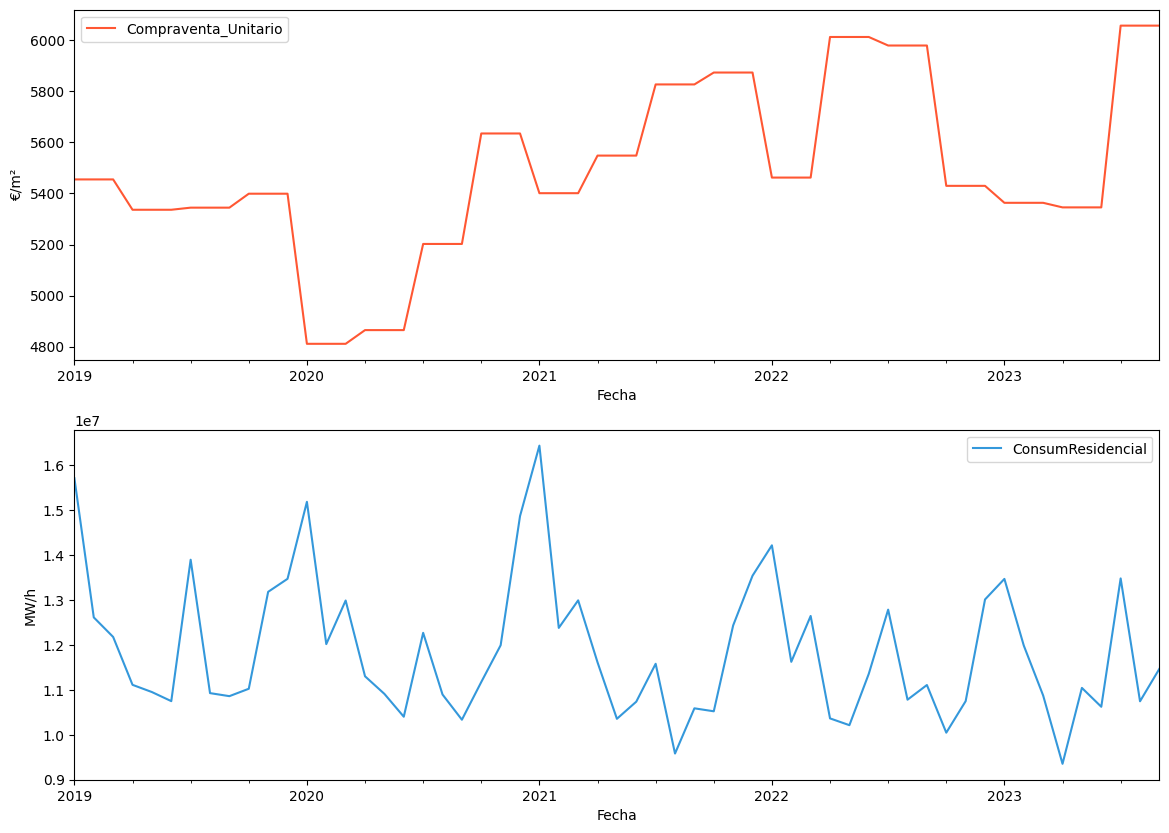

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'MW/h']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,ConsumResidencial
Compraventa_Unitario,1.000000,-0.124281
ConsumResidencial,-0.124281,1.000000


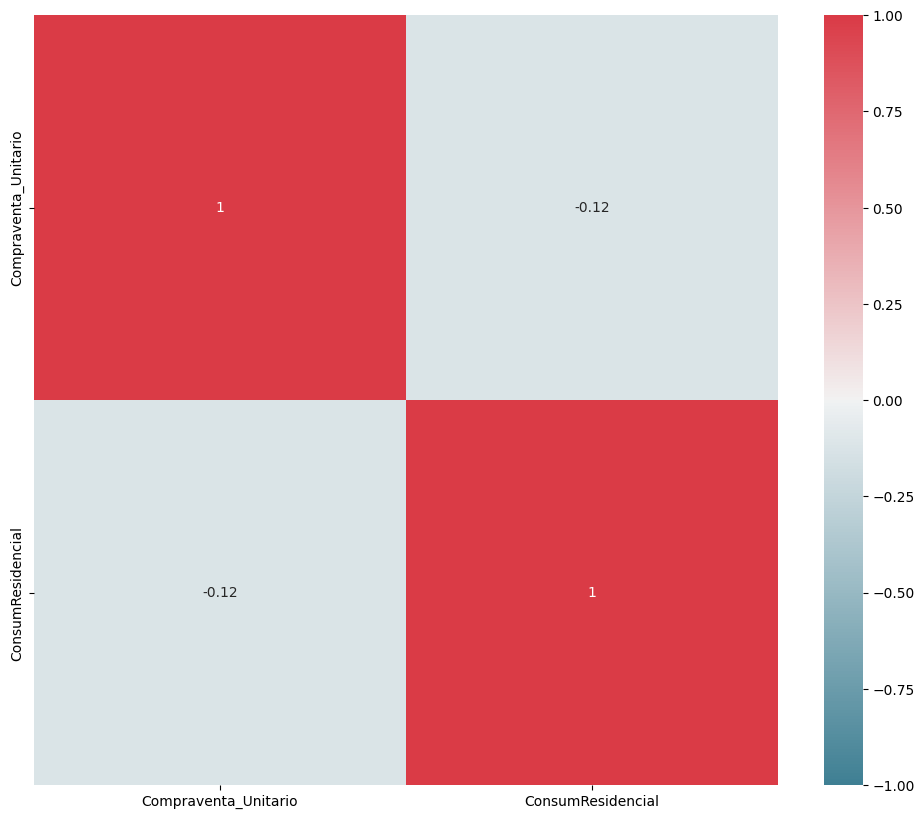

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "ConsumResidencial" es de -0.124281, lo que sugiere una correlación negativa moderada entre estas dos variables en el modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2023-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(48, 2) (9, 2)


###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario','ConsumResidencial']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  7.08      > 12.3212   =>   False
ConsumResidencial >  0.29      > 4.1296    =>   False


* **Compraventa_Unitario**: No hay suficiente evidencia estadística para rechazar la hipótesis nula de no cointegración. Esto sugiere que "Compraventa_Unitario" no tiene una relación de equilibrio estacionario de largo plazo con las otras series en el sistema.
* **ConsumResidencial** : Similarmente, "ConsumResidencial " tampoco muestra evidencia de cointegración. No existe una combinación lineal estacionaria que vincule esta serie con otras en el sistema a largo plazo.

Para un análisis conjunto que aún considera las interacciones entre múltiples series no cointegradas, usaremos un modelo VAR (Vector Autoregressive) o VARMA (Vector Autoregressive Moving Average) y descartaremos el modelo VECM (Vector Error Correlation Model), pero primero transformaremos comprobaremos y transformaremos por diferenciacion las veces necesrarias para convertir las series en estacionarias



### Prueba de estacionariedad

Un requisito indispensable para poder aplicar los modelo, es que los datos sean estacionarios. Para comprobarlo realizaremos el Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.



In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.333200
Serie de tiempo ConsumResidencial
p-value: 0.000001


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2019-02-01,0.000000,-3.097110e+06
2019-03-01,0.000000,-4.351532e+05
2019-04-01,-118.933333,-1.065591e+06
2019-05-01,0.000000,-1.604777e+05
2019-06-01,0.000000,-2.022585e+05


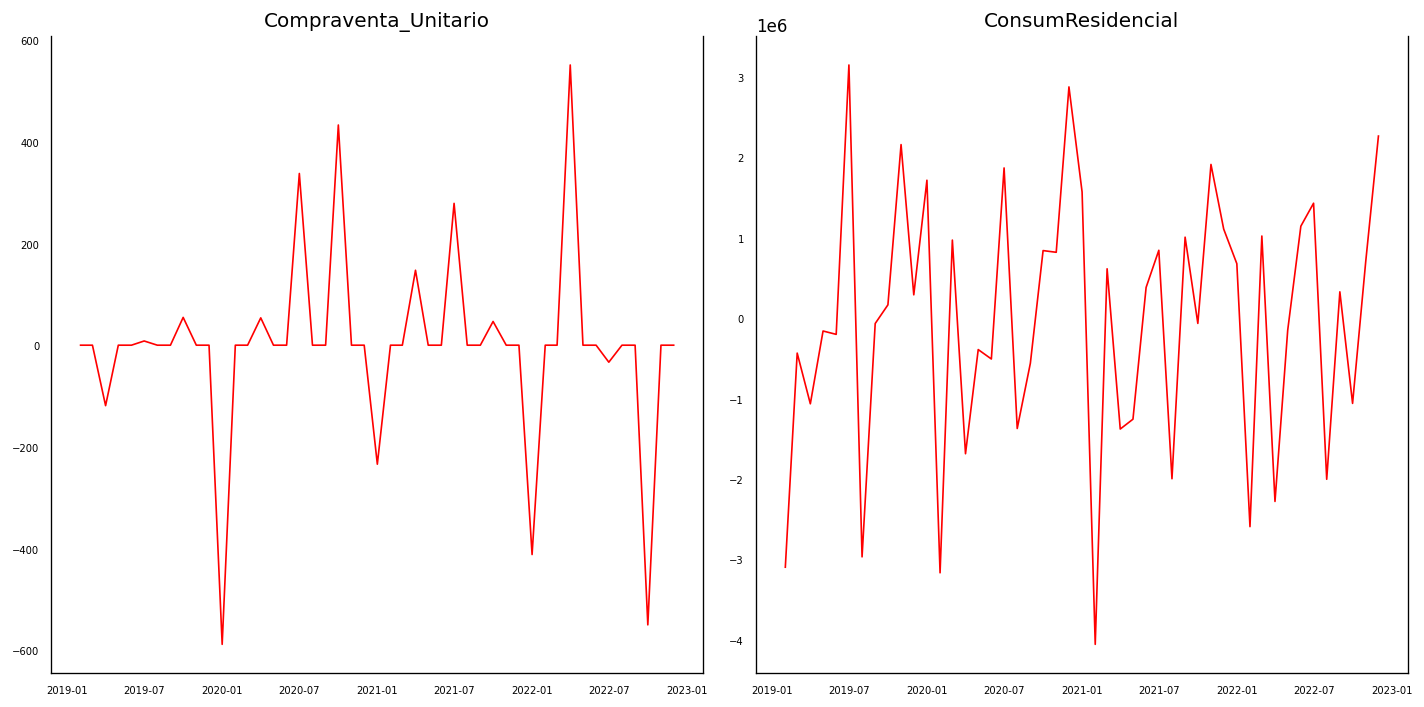

In [23]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000410
Serie de tiempo transformada Variable ConsumResidencial
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola serie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de sus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




#### Seleccionando el orden del modelo

In [64]:
from statsmodels.tsa.api import VAR

In [65]:
model = VAR(X_train_transformed)

In [66]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,39.26,39.34*,1.121e+17,39.29
1,39.36,39.62,1.241e+17,39.45
2,39.39,39.81,1.277e+17,39.54
3,39.31,39.91,1.195e+17,39.53
4,39.46,40.23,1.402e+17,39.74
5,39.44,40.38,1.394e+17,39.78
6,38.95,40.06,8.650e+16,39.34
7,38.91,40.19,8.582e+16,39.37
8,38.63*,40.08,6.804e+16*,39.15*


En este caso, los criterios AIC, FPE y HQIC sugieren que el orden óptimo del modelo VAR es 8, ya que tienen los valores más bajos en esa fila. Sin embargo, el criterio BIC indica que el orden óptimo es 0.

#### Ajustando el modelo

In [67]:
res = model.fit(maxlags=8)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, May, 2024
Time:                     18:55:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    40.0842
Nobs:                     39.0000    HQIC:                   39.1542
Log likelihood:          -830.038    FPE:                6.80420e+16
AIC:                      38.6339    Det(Omega_mle):     3.30012e+16
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -2.069567        30.148993           -0.069           0.945
L1.Compraventa_Unitario        -0.065652         0.207536           -0.316           0.752
L1.Co

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "ConsumResidencial" es de -0.930311, lo que sugiere una correlación negativa alta entre los residuos de estas dos variables en tu modelo.

In [68]:
res.is_stable()

True

In [69]:
X_train_transformed.columns

Index(['Compraventa_Unitario', 'ConsumResidencial'], dtype='object')

###### Causalidad de Granger

In [70]:
grangercaus=res.test_causality(['ConsumResidencial'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.934,2.157,0.010,"(8, 44)"


In [71]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['ConsumResidencial'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.870,2.157,0.089,"(8, 44)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [72]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train, variables = X_train.columns)

,Compraventa_Unitario_x,ConsumResidencial_x
Compraventa_Unitario_y,1.0,0.0
ConsumResidencial_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

#### Diagnosis del modelo


###### Residuos

In [73]:
residuals=res.resid

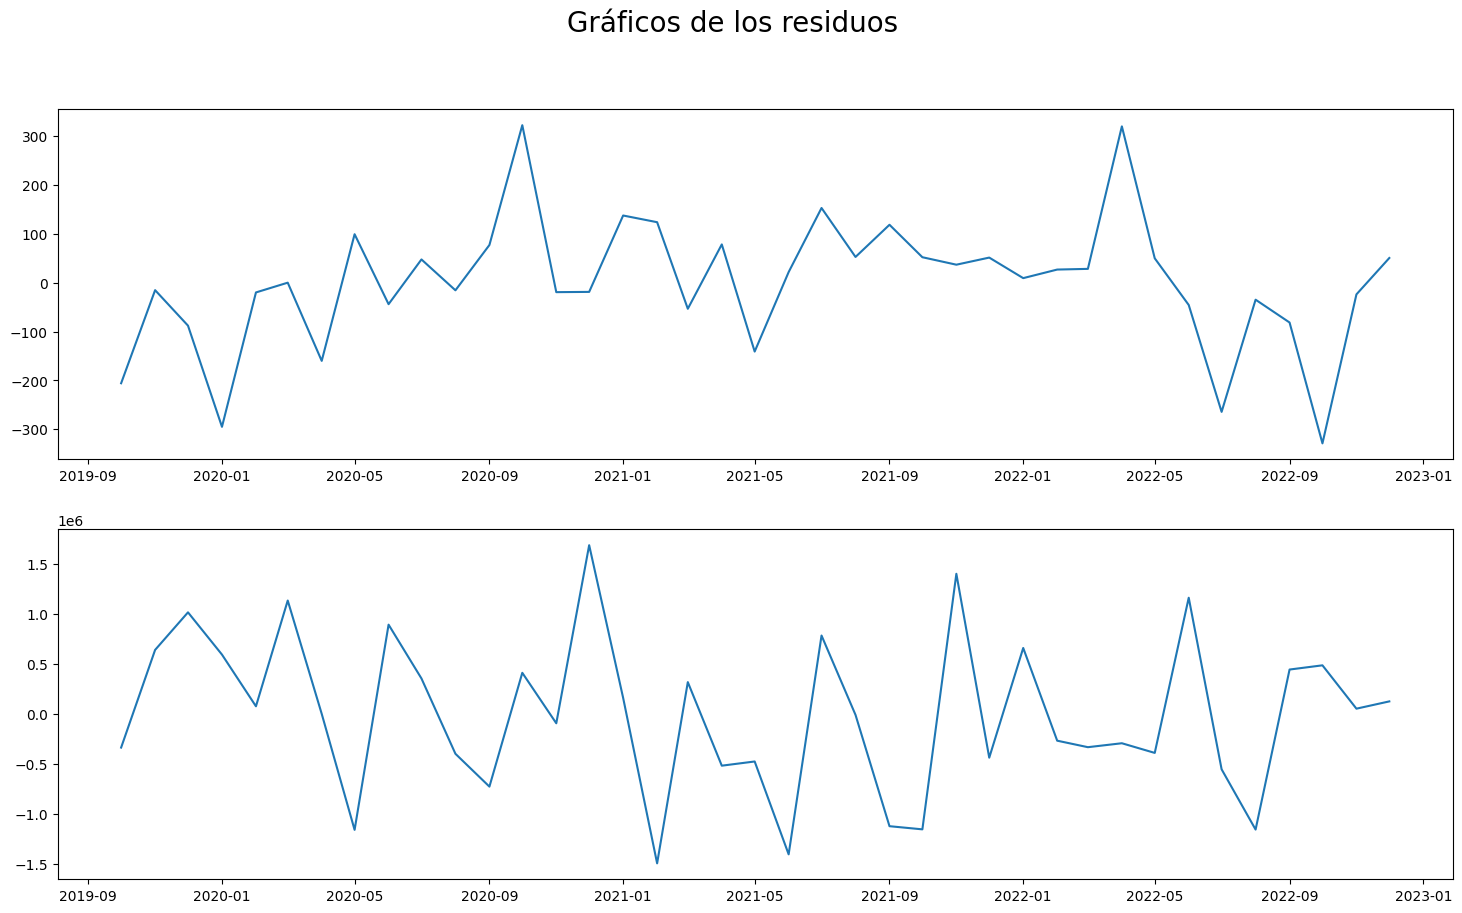

In [74]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [75]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[1.2733592495912274e-05, 1.2610429807006433e-06]

Los resultados del test ADF (Augmented Dickey-Fuller) para los residuos muestran un p-valor extremadamente bajo para la primera serie temporal (4.625040755237305e-06), lo que sugiere que podemos rechazar la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que indica que la serie es estacionaria. Sin embargo, para la segunda serie temporal, el p-valor es significativamente alto (0.8413587077119747), lo que sugiere que no podemos rechazar la hipótesis nula y que la serie temporal no es estacionaria.



###### ACF de los Residuos


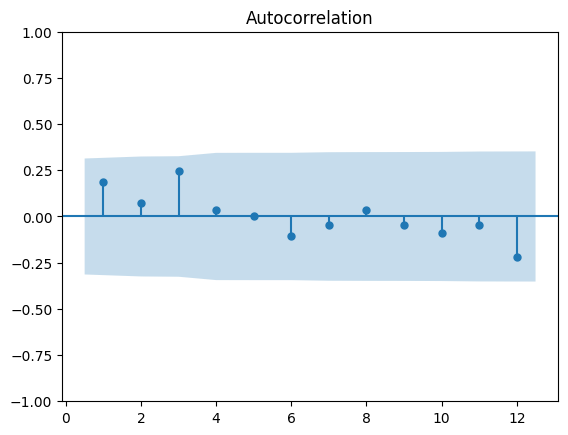

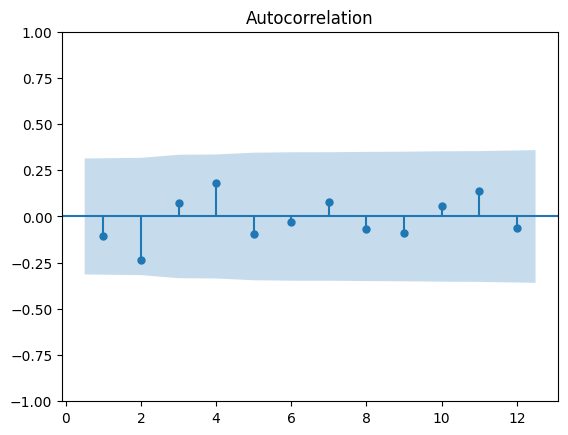

In [76]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


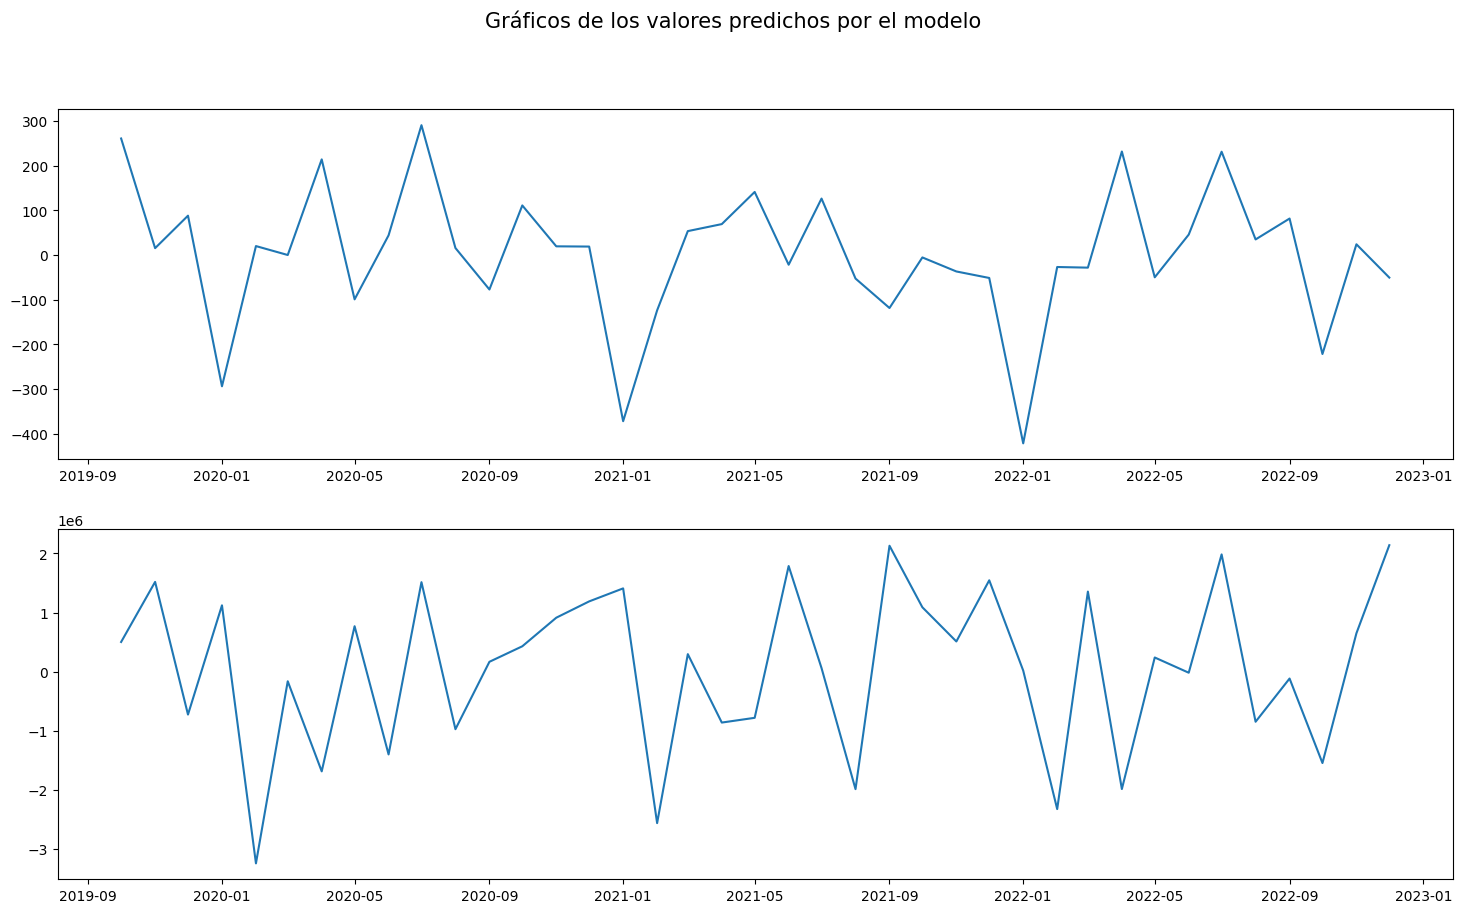

In [77]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [78]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns))
print('Predicciones:')
pred

Orden del modelo: 8
Predicciones:


,Compraventa_Unitario,ConsumResidencial
Fecha,,
2023-01-01,-254.491165,-1.554855e+06
2023-02-01,-252.957624,-1.843269e+06
2023-03-01,-44.965482,3.174929e+05
2023-04-01,543.977998,-1.501684e+05
2023-05-01,-51.474391,7.644017e+05
2023-06-01,-71.614198,-1.134718e+06
2023-07-01,86.676815,1.340251e+05
2023-08-01,318.563553,3.401703e+05
2023-09-01,183.614152,1.039882e+06


<Figure size 1200x1000 with 0 Axes>

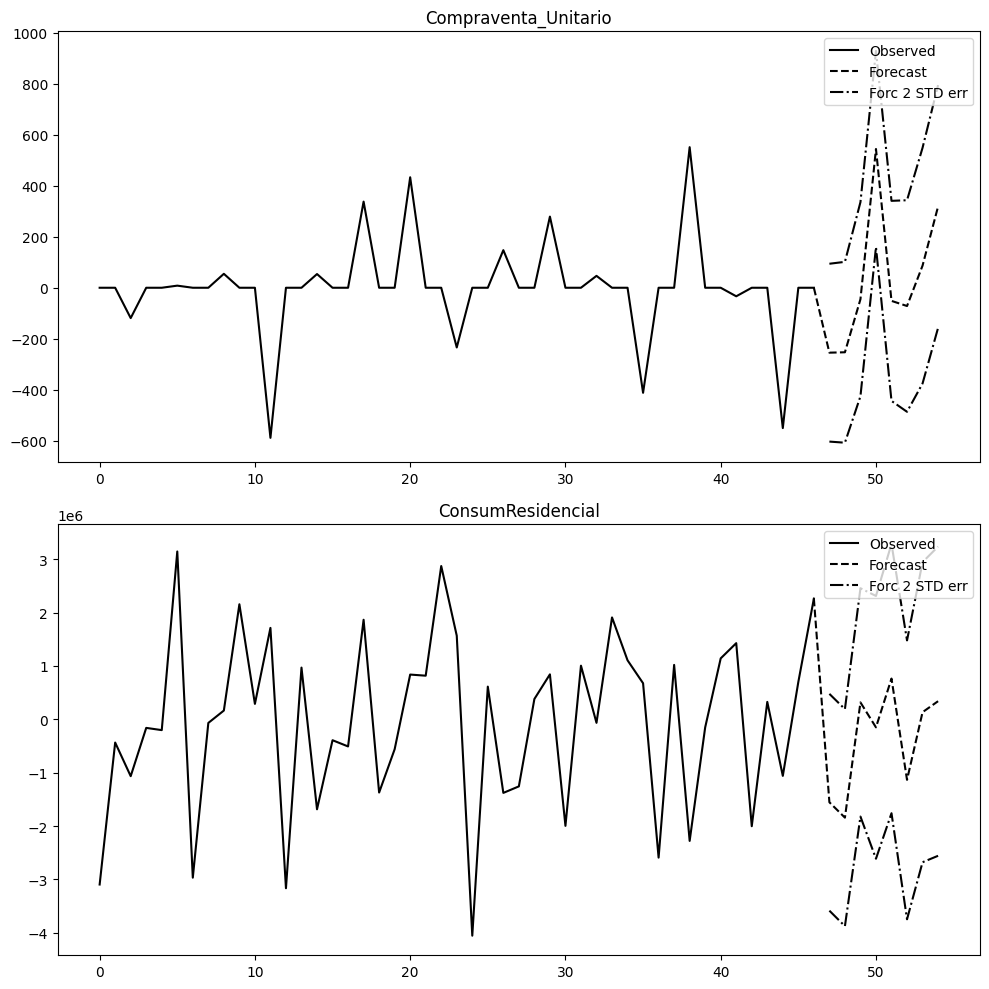

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)


In [80]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [81]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,ConsumResidencial
Fecha,,
2023-01-01,5175.492168,1.145592e+07
2023-02-01,4922.534544,9.612649e+06
2023-03-01,4877.569062,9.930142e+06
2023-04-01,5421.547060,9.779974e+06
2023-05-01,5370.072670,1.054438e+07
2023-06-01,5298.458472,9.409657e+06
2023-07-01,5385.135287,9.543682e+06
2023-08-01,5703.698840,9.883853e+06
2023-09-01,5887.312992,1.092374e+07


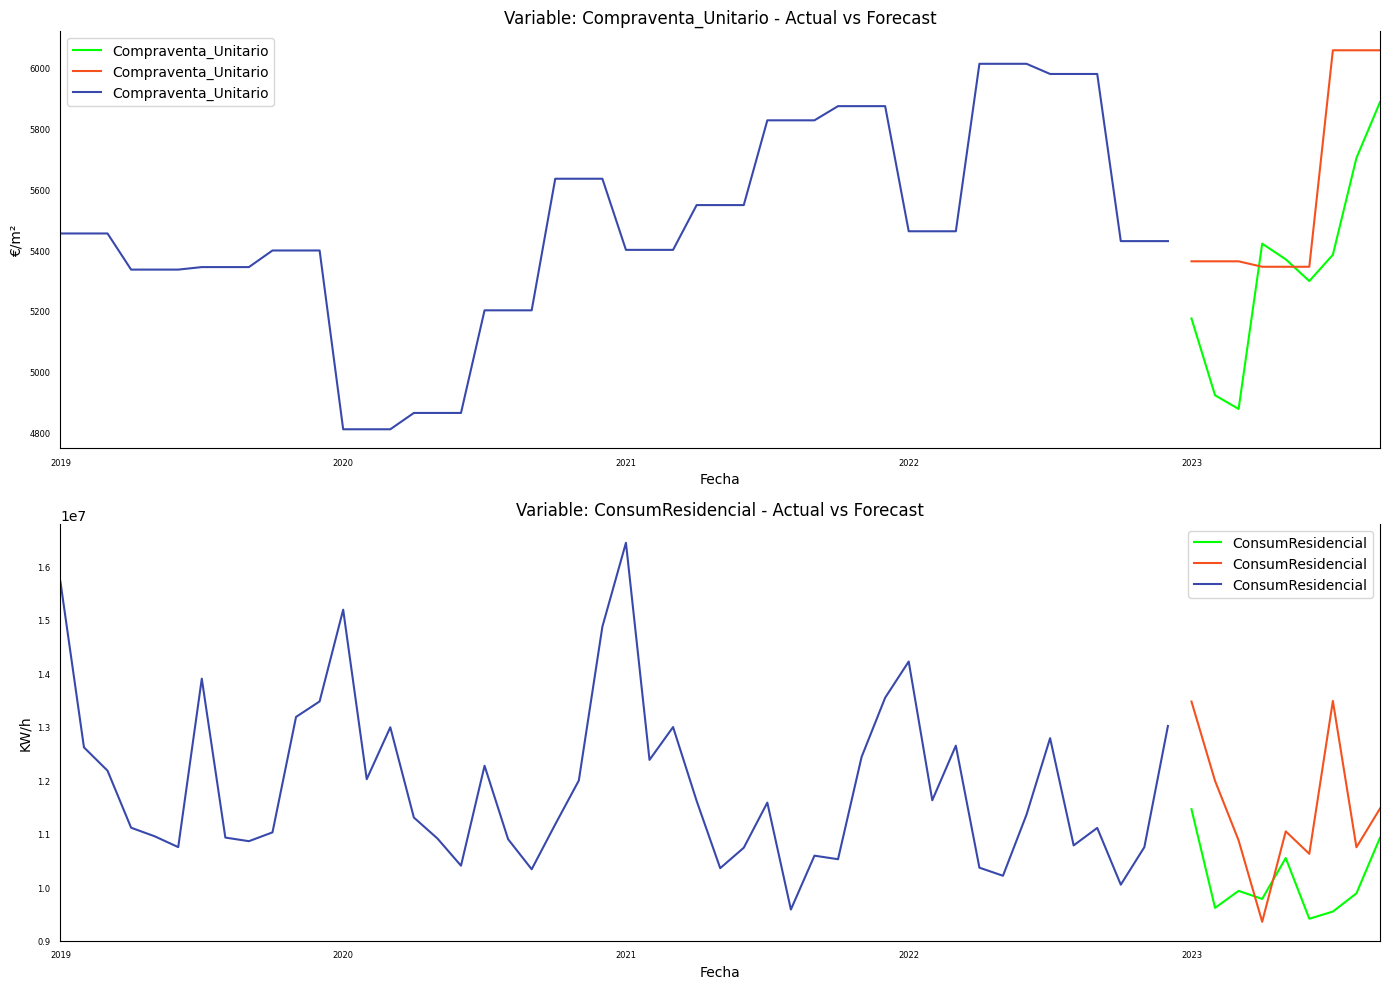

In [82]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [83]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [84]:
for i in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 120228.50107387244
MAE is : 273.3909295319464
RMSE is : 346.7398175489403
MAPE is : 4.813717629204247
R2 is : -0.09241581050608194

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 3221346390513.83
MAE is : 1422929.8061985371
RMSE is : 1794810.9623338694
MAPE is : 11.76207211180574
R2 is : -0.9921323160787376



Las métricas de evaluación para Compraventa_Unitario muestran un MSE de 59,326,614.68, MAE de 7,627.56, RMSE de 7,702.38, MAPE de 137.76%, y un R² de -538.05, indicando un modelo con baja precisión y alto error. Para ConsumResidencial, las métricas son aún peores, con un MSE de 354,363,716,678,149.94, MAE de 15,029,624.63, RMSE de 18,824,550.90, MAPE de 138.86%, y un R² de -218.14. Ambos conjuntos de datos muestran que los modelos actuales tienen un desempeño muy pobre, sugiriendo la necesidad de ajustes significativos.

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 711601.5985640346
Root mean squared error: 1269123.026097614


### Modelo VARMA (Auto Arima)

El modelo VARMA (Vector Autoregressive Moving Average) es una técnica estadística utilizada en análisis de series temporales que combina los modelos VAR (Vector Autoregressive) y MA (Moving Average). Es especialmente útil cuando se trata de series temporales múltiples, permitiendo modelar la interdependencia entre varias series a lo largo del tiempo junto con términos de error autocorrelacionados.


In [86]:
!pip install pmdarima

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [48]:
import pmdarima as pm

In [89]:
pq = []
for name in ['Compraventa_Unitario', 'ConsumResidencial']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=627.892, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=629.892, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=629.892, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=625.892, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=631.836, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.150 seconds
optimal order for:Compraventa_Unitario is: (0, 1, 0) 


Searching order of p and q for : ConsumResidencial
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1703.298, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1674.372, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1517.996, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1513.982, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[0]   

In [90]:
pq

[(0, 1, 0), (2, 0, 1)]

Se realizó una búsqueda paso a paso para seleccionar los modelos ARIMA óptimos para las series Compraventa_Unitario y ConsumResidencial, minimizando el AIC. Para Compraventa_Unitario, el mejor modelo fue ARIMA(0,1,0) con un AIC de 625.892. Para ConsumResidencial, el mejor modelo fue ARIMA(2,0,1) con un AIC de 1513.982. Estos modelos presentaron los valores de AIC más bajos entre los probados, indicando su adecuación para la predicción de cada serie.

#####Seleccion del modelo

In [51]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [91]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','ConsumResidencial']], order=(2,1)).fit(disp=False)

In [92]:
model.summary()

Dep. Variable:,"['Compraventa_Unitario', 'ConsumResidencial']",No. Observations:,47
Model:,"VARMA(2,1)",Log Likelihood,-1045.636
,+ intercept,AIC,2125.272
Date:,"Thu, 16 May 2024",BIC,2156.725
Time:,19:01:38,HQIC,2137.108
Sample:,02-01-2019,,
,- 12-01-2022,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.00",Jarque-Bera (JB):,"31.29, 1.55"
Prob(Q):,"0.95, 0.96",Prob(JB):,"0.00, 0.46"
Heteroskedasticity (H):,"2.23, 0.81",Skew:,"-0.58, 0.15"


#### Valores predichos


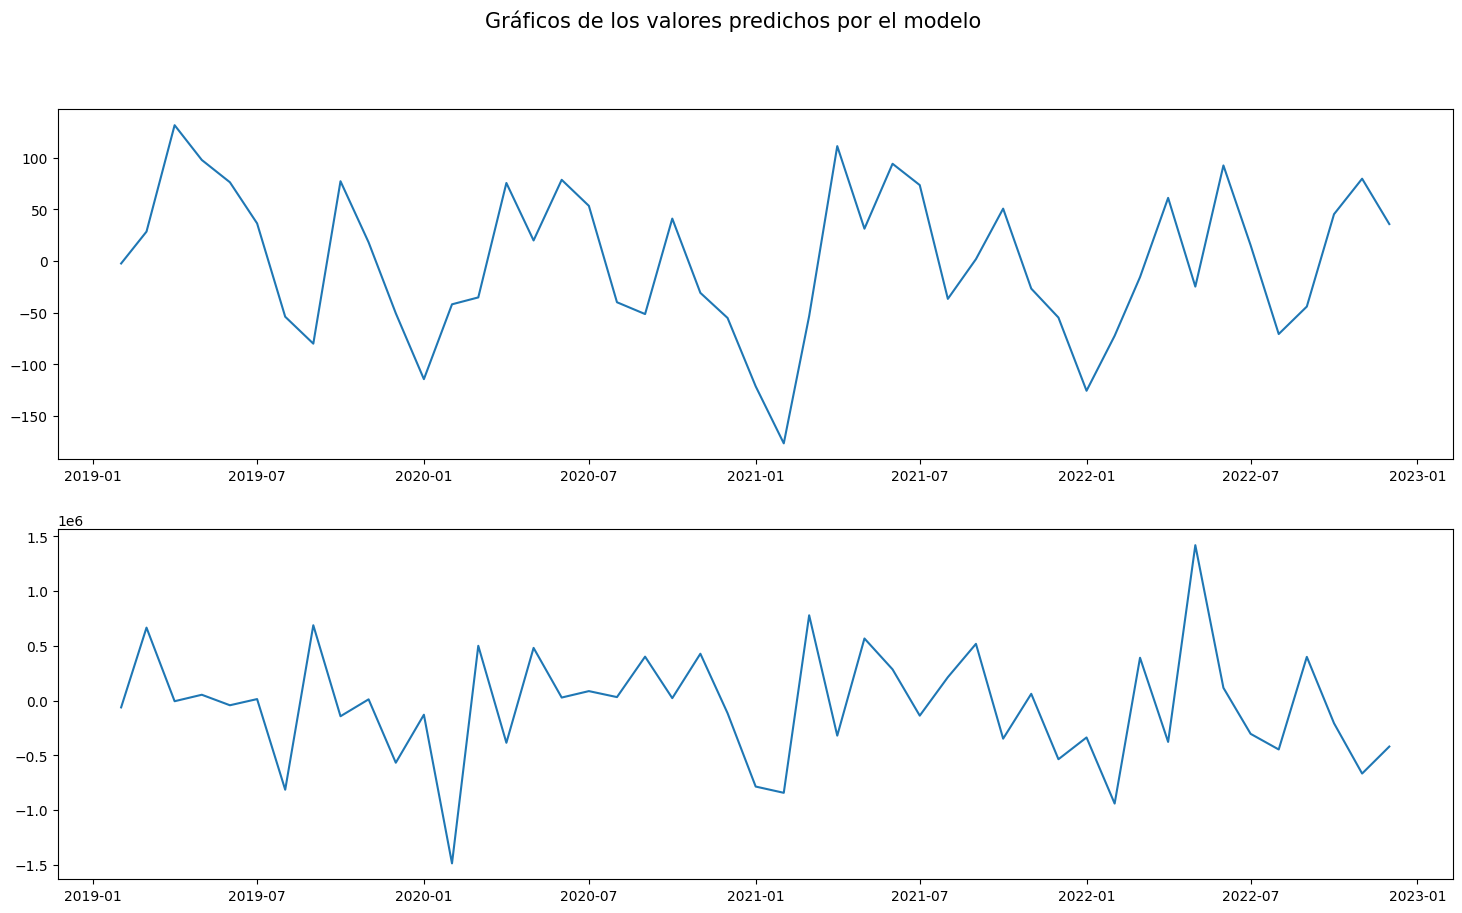

In [93]:
y_fitted = model.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [94]:
result = model.forecast(steps = 9)

In [95]:
result

,Compraventa_Unitario,ConsumResidencial
2023-01-01,-71.684689,-601252.888511
2023-02-01,-99.816339,-34481.369214
2023-03-01,-14.503978,-307687.216530
2023-04-01,-6.087118,-64619.052381
2023-05-01,4.739699,-79262.035249
2023-06-01,-0.052446,-44918.767667
2023-07-01,-1.180405,-59364.559905
2023-08-01,-2.629206,-59294.973714
2023-09-01,-2.590197,-63051.437944


#### Invertiendo la transformacion de los pronosticos a la escala original

In [96]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [97]:
res = inverse_diff(X_train[['Compraventa_Unitario', 'ConsumResidencial']],result,False)

In [98]:
res

,Compraventa_Unitario,ConsumResidencial
2023-01-01,5358.298644,1.240952e+07
2023-02-01,5258.482306,1.237504e+07
2023-03-01,5243.978327,1.206735e+07
2023-04-01,5237.891209,1.200273e+07
2023-05-01,5242.630908,1.192347e+07
2023-06-01,5242.578462,1.187855e+07
2023-07-01,5241.398057,1.181919e+07
2023-08-01,5238.768851,1.175989e+07
2023-09-01,5236.178654,1.169684e+07


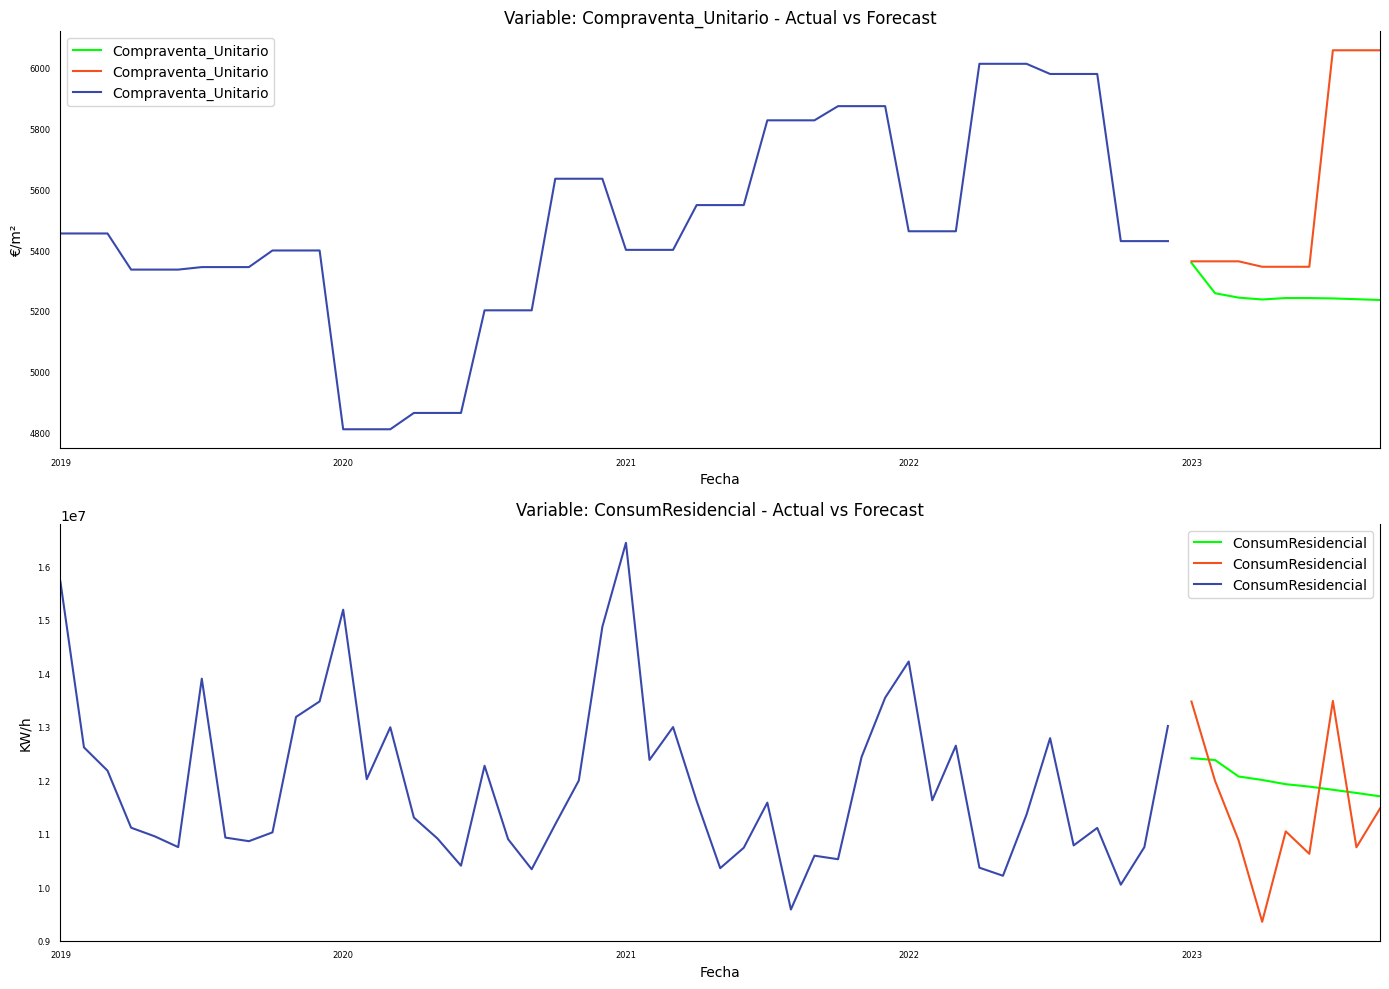

In [99]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'KW/h']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [100]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [101]:
for i in ['Compraventa_Unitario','ConsumResidencial']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 230210.0158087368
MAE is : 333.4549534207815
RMSE is : 479.80205898759624
MAPE is : 5.635499979907502
R2 is : -1.0917258284023537

Evaluation metric for ConsumResidencial
Evaluation metric results:-
MSE is : 1767730186858.1868
MAE is : 1148030.4033661473
RMSE is : 1329560.1478903415
MAPE is : 10.441980868548407
R2 is : -0.09319272268214052



Las métricas para Compraventa_Unitario muestran altos errores (MSE: 230210, RMSE: 479.8) y un R² negativo (-1.09), indicando un mal ajuste del modelo. El MAPE de 5.64% sugiere errores absolutos relativamente moderados. Para ConsumResidencial, los errores son extremadamente altos (MSE: 1767730186858, RMSE: 1329560) y el R² es también negativo (-0.09), reflejando un ajuste deficiente. El MAPE de 10.44% indica errores significativos en proporción a los valores reales. En resumen, ambos modelos requieren mejoras sustanciales para mejorar su precisión predictiva.

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 574181.929159784
Root mean squared error: 940141.0577855333


##Conclusiones

Se analizaron las series temporales "Compraventa_Unitario" y "ConsumResidencial" mediante modelos VAR y VARMA. No se encontraron pruebas suficientes de cointegración entre las series, indicando que no tienen una relación de equilibrio a largo plazo.

**Modelo VAR**: Se seleccionó un modelo VAR de orden 8 basado en criterios AIC, FPE y HQIC. Los residuos del modelo fueron verificados como estacionarios, aunque el test de causalidad de Granger indicó que ninguna serie puede predecir la otra. Las métricas de evaluación mostraron altos errores (MAE de 7,627.56 para "Compraventa_Unitario" y 15,029,624.63 para "ConsumResidencial") y MAPE elevados (137.76% y 138.86%), sugiriendo un mal ajuste y baja precisión predictiva.

**Modelo VARMA:** Utilizando auto-arima, se determinaron los parámetros óptimos para el modelo VARMA, seleccionándose un modelo VARMA(2,1). Las predicciones de este modelo también fueron des-transformadas para compararlas con los datos originales. Las métricas de evaluación mostraron igualmente altos errores (MAE de 479.8 para "Compraventa_Unitario" y 1,329,560 para "ConsumResidencial") y MAPE significativos (5.64% y 10.44%), indicando una baja precisión predictiva. Además, los valores R² negativos reflejan que los modelos no explican adecuadamente la variabilidad de los datos.

Conclusión: Ambos modelos, VAR y VARMA, no lograron predecir con precisión los valores futuros de las series temporales analizadas. Se recomienda incluir variables exógenas, probar diferentes métodos de diferenciación, y explorar otros enfoques de modelado multivariado para mejorar la precisión. Estos resultados destacan la necesidad de refinamientos adicionales en el enfoque de modelado para obtener mejores resultados.